# RQ3 — Perfiles tecnológicos y diferencias salariales

## Research Question 3 (RQ3)
**¿Existen perfiles (clusters) de desarrolladores según su stack tecnológico y difieren en salario?**

En esta sección se agrupan desarrolladores según tecnologías reportadas (lenguajes, bases de datos, frameworks, plataformas y herramientas) utilizando técnicas de *clustering*. Posteriormente, se evalúa si los perfiles encontrados presentan diferencias significativas en salario.


## 1. Carga de datos y librerías

Se utiliza el dataset procesado `df_final_v1.csv`, el mismo empleado en RQ1, para mantener consistencia en limpieza, transformación de salario (`log_salary`) y filtrado.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.stats import kruskal
from itertools import combinations
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

df = pd.read_csv("../data/processed/df_final_v1.csv")
df.shape


(65437, 21)

## 2. Preparación de datos para RQ3

Para el análisis se consideran únicamente desarrolladores con salario reportado (`has_salary == True`) y que tengan información disponible en al menos una categoría del stack tecnológico.


In [2]:
stack_cols = [
    "LanguageHaveWorkedWith",
    "DatabaseHaveWorkedWith",
    "WebframeHaveWorkedWith",
    "PlatformHaveWorkedWith",
    "ToolsTechHaveWorkedWith"
]
salary_col = "log_salary"

rq3_df = df[df["has_salary"] == True].copy()
rq3_df = rq3_df.dropna(subset=stack_cols, how="all")
rq3_df = rq3_df[stack_cols + [salary_col]].copy()

print("Filas para RQ3:", rq3_df.shape[0])
rq3_df.head()


Filas para RQ3: 23387


,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,WebframeHaveWorkedWith,PlatformHaveWorkedWith,ToolsTechHaveWorkedWith,log_salary
72,Assembly;Bash/Shell (all shells);C;C++;HTML/CS...,MongoDB;MySQL;SQLite,Angular;AngularJS;Express;FastAPI;Flask;jQuery...,Microsoft Azure;VMware,Docker;Homebrew;Pip,8.898775
374,C;C++;Fortran;MATLAB;Python;SQL,PostgreSQL,NaN,NaN,NaN,10.311450
379,JavaScript;Julia;Python;SQL;TypeScript,DuckDB;PostgreSQL;SQLite,Next.js;React;Vue.js,Amazon Web Services (AWS);Cloudflare;Digital O...,Ansible;Make;Vite,11.421862
385,Python,BigQuery;MongoDB;PostgreSQL;Snowflake,Django,Amazon Web Services (AWS);Google Cloud,Ansible;Docker;Kubernetes;Pip,10.891243
389,HTML/CSS;JavaScript;Python;SQL;TypeScript,IBM DB2;MySQL;SQLite,FastAPI;Flask;Node.js;Vue.js,Amazon Web Services (AWS),Homebrew;npm;Pip;Vite;Webpack,11.608245


## 3. Ingeniería de features: stack tecnológico a variables numéricas

Las variables tecnológicas se encuentran en formato texto con múltiples selecciones separadas por `;`. Para aplicar clustering es necesario transformarlas a una matriz binaria (*one-hot encoding*), donde cada columna representa una tecnología y cada fila indica si el desarrollador la ha usado (1) o no (0).


In [3]:
encoded_parts = []

for col in stack_cols:
    temp = rq3_df[col].fillna("")
    dummies = temp.str.get_dummies(sep=";")
    dummies = dummies.add_prefix(col + "__")
    encoded_parts.append(dummies)

X = pd.concat(encoded_parts, axis=1)

print("Matriz X:", X.shape)
X.head()


Matriz X: (23387, 181)


,LanguageHaveWorkedWith__Ada,LanguageHaveWorkedWith__Apex,LanguageHaveWorkedWith__Assembly,LanguageHaveWorkedWith__Bash/Shell (all shells),LanguageHaveWorkedWith__C,LanguageHaveWorkedWith__C#,LanguageHaveWorkedWith__C++,LanguageHaveWorkedWith__Clojure,LanguageHaveWorkedWith__Cobol,LanguageHaveWorkedWith__Crystal,...,ToolsTechHaveWorkedWith__Puppet,ToolsTechHaveWorkedWith__Terraform,ToolsTechHaveWorkedWith__Unity 3D,ToolsTechHaveWorkedWith__Unreal Engine,ToolsTechHaveWorkedWith__Visual Studio Solution,ToolsTechHaveWorkedWith__Vite,ToolsTechHaveWorkedWith__Webpack,ToolsTechHaveWorkedWith__Yarn,ToolsTechHaveWorkedWith__npm,ToolsTechHaveWorkedWith__pnpm
72,0,0,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
374,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
379,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
389,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0


## 4. Filtrado de tecnologías poco frecuentes

Para reducir ruido y mejorar interpretabilidad, se eliminan tecnologías reportadas por menos del **1%** de los desarrolladores en la muestra. Esto reduce dimensionalidad y evita que tecnologías muy raras afecten la formación de clusters.


In [4]:
tech_counts = X.sum(axis=0)
tech_freq = tech_counts / X.shape[0]

min_freq = 0.01
cols_to_keep = tech_freq[tech_freq >= min_freq].index
X_filtered = X[cols_to_keep]

print("Columnas antes:", X.shape[1])
print("Columnas después:", X_filtered.shape[1])


Columnas antes: 181
Columnas después: 148


## 5. Normalización

Se aplica normalización por fila (norma L2) para evitar que desarrolladores que reportaron muchas tecnologías dominen el clustering únicamente por tener más selecciones.


In [5]:
X_norm = normalize(X_filtered, norm="l2")
print("X_norm:", X_norm.shape)


X_norm: (23387, 148)


## 6. Selección del número de clusters (k)

Se evalúan múltiples valores de *k* utilizando:
- **Elbow Method (Inertia)**: busca el punto donde la mejora marginal se reduce.
- **Silhouette Score**: mide la separación entre clusters.

Se selecciona **k = 5** por presentar un buen balance entre interpretabilidad, inertia y silhouette score.


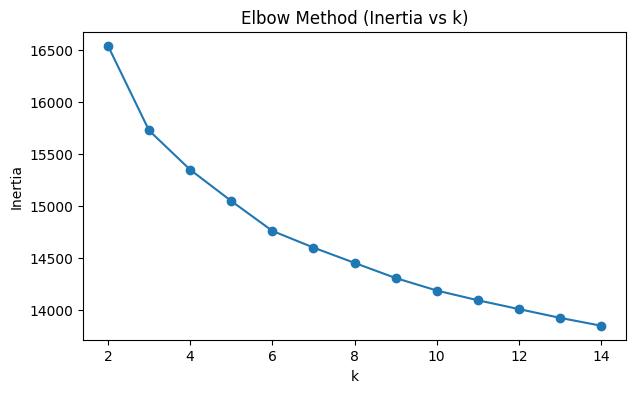

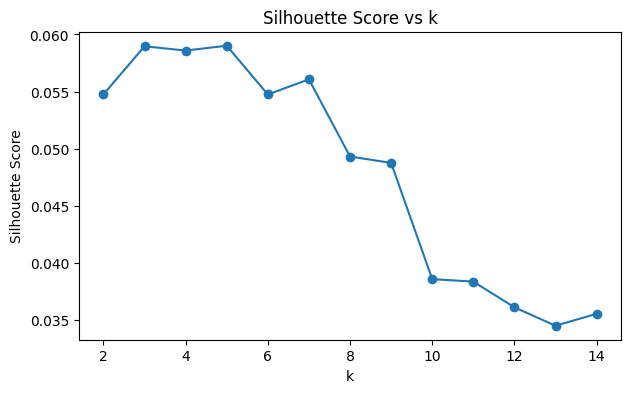

In [6]:
inertias = []
sil_scores = []
k_values = range(2, 15)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_norm)

    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_norm, labels))

plt.figure(figsize=(7,4))
plt.plot(list(k_values), inertias, marker="o")
plt.title("Elbow Method (Inertia vs k)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

plt.figure(figsize=(7,4))
plt.plot(list(k_values), sil_scores, marker="o")
plt.title("Silhouette Score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.show()


## 7. Entrenamiento final del modelo de clustering

Con **k = 5**, se entrena el modelo final y se asigna a cada desarrollador un perfil tecnológico (cluster).


In [7]:
k_final = 5
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_norm)

rq3_results = rq3_df.copy()
rq3_results["cluster"] = clusters

rq3_results["cluster"].value_counts().sort_index()


cluster
0    4845
1    3769
2    4360
3    7531
4    2882
Name: count, dtype: int64

## 8. Interpretación de clusters

Para interpretar cada perfil tecnológico, se obtienen las tecnologías más frecuentes dentro de cada cluster.


In [8]:
top_n = 10

for c in sorted(rq3_results["cluster"].unique()):
    print(f"\n===== Cluster {c} =====")
    cluster_mask = (rq3_results["cluster"] == c)
    tech_means = X_filtered[cluster_mask].mean().sort_values(ascending=False)
    print(tech_means.head(top_n))



===== Cluster 0 =====
LanguageHaveWorkedWith__Python                       0.774613
ToolsTechHaveWorkedWith__Docker                      0.720743
DatabaseHaveWorkedWith__PostgreSQL                   0.696801
LanguageHaveWorkedWith__SQL                          0.600619
PlatformHaveWorkedWith__Amazon Web Services (AWS)    0.597317
ToolsTechHaveWorkedWith__Pip                         0.502786
LanguageHaveWorkedWith__Bash/Shell (all shells)      0.475129
LanguageHaveWorkedWith__JavaScript                   0.387616
ToolsTechHaveWorkedWith__Kubernetes                  0.363261
DatabaseHaveWorkedWith__SQLite                       0.326729
dtype: float64

===== Cluster 1 =====
LanguageHaveWorkedWith__Java                         0.947201
ToolsTechHaveWorkedWith__Maven (build tool)          0.662775
ToolsTechHaveWorkedWith__Docker                      0.617936
LanguageHaveWorkedWith__JavaScript                   0.589016
LanguageHaveWorkedWith__SQL                          0.586628
DatabaseH

## 9. Etiquetado de perfiles tecnológicos

Con base en las tecnologías dominantes, se asignan nombres interpretables a cada cluster.


In [9]:
cluster_names = {
    0: "Python Backend/Data + Cloud",
    1: "Java/Spring Backend",
    2: ".NET / Microsoft Enterprise",
    3: "Modern JS Fullstack (React/Node)",
    4: "Systems / Low-level + Python"
}

rq3_results["profile"] = rq3_results["cluster"].map(cluster_names)
rq3_results[["cluster", "profile"]].head()


,cluster,profile
72,4,Systems / Low-level + Python
374,4,Systems / Low-level + Python
379,3,Modern JS Fullstack (React/Node)
385,0,Python Backend/Data + Cloud
389,3,Modern JS Fullstack (React/Node)


## 10. Diferencias salariales entre perfiles

Se evalúan diferencias en salario entre perfiles utilizando:

- Visualización con boxplots en escala `log_salary` y escala real estimada.
- Prueba **Kruskal–Wallis** para evaluar diferencias globales.
- Comparaciones post-hoc por pares (Mann–Whitney + corrección FDR) para identificar qué perfiles difieren.


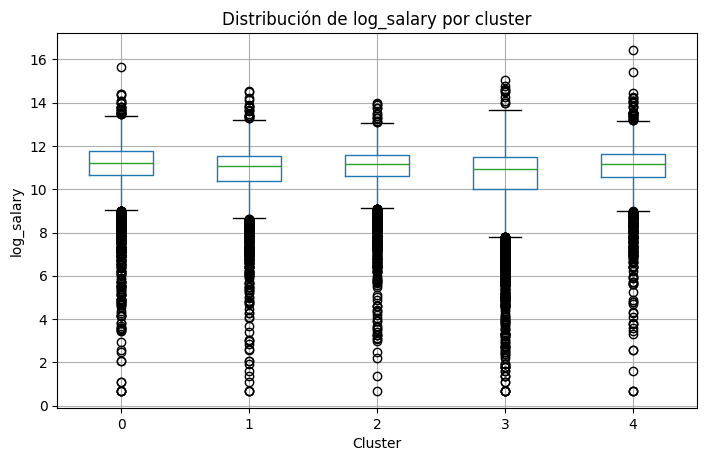

Kruskal-Wallis H = 440.1025950636681
p-value = 5.990027479731105e-94


In [10]:
rq3_results.boxplot(column="log_salary", by="cluster", figsize=(8,5))
plt.title("Distribución de log_salary por cluster")
plt.suptitle("")
plt.xlabel("Cluster")
plt.ylabel("log_salary")
plt.show()

groups = [rq3_results[rq3_results["cluster"] == c]["log_salary"] 
          for c in sorted(rq3_results["cluster"].unique())]

stat, p = kruskal(*groups)

print("Kruskal-Wallis H =", stat)
print("p-value =", p)


In [11]:
pairs = list(combinations(sorted(rq3_results["cluster"].unique()), 2))
p_values = []
results = []

for a, b in pairs:
    group_a = rq3_results[rq3_results["cluster"] == a]["log_salary"]
    group_b = rq3_results[rq3_results["cluster"] == b]["log_salary"]
    
    stat_u, p_u = mannwhitneyu(group_a, group_b, alternative="two-sided")
    p_values.append(p_u)
    results.append((a, b, stat_u, p_u))

reject, pvals_corrected, _, _ = multipletests(p_values, method="fdr_bh")

posthoc_df = pd.DataFrame({
    "Cluster_A": [r[0] for r in results],
    "Cluster_B": [r[1] for r in results],
    "p_raw": p_values,
    "p_corrected": pvals_corrected,
    "significant": reject
}).sort_values("p_corrected")

posthoc_df


,Cluster_A,Cluster_B,p_raw,p_corrected,significant
2,0,3,1.524059e-81,1.524059e-80,True
7,2,3,1.177513e-37,5.887563e-37,True
9,3,4,8.482596e-31,2.827532e-30,True
0,0,1,2.661675e-26,6.654187e-26,True
5,1,3,4.403481e-12,8.806962e-12,True
1,0,2,1.205468e-10,2.009114e-10,True
4,1,2,5.665553e-07,8.093647e-07,True
6,1,4,1.153048e-06,1.441310e-06,True
3,0,4,1.926429e-06,2.140476e-06,True
8,2,4,6.064723e-01,6.064723e-01,False


## 11. Resultados en escala salarial real (USD)

Para facilitar interpretación, se convierte `log_salary` nuevamente a escala salarial aproximada mediante:

\[
salary \approx e^{log\_salary} - 1
\]

La mediana salarial por perfil permite comparar diferencias en términos monetarios.


In [12]:
rq3_results["salary_est"] = np.exp(rq3_results["log_salary"]) - 1

final_summary = rq3_results.groupby("profile").agg(
    count=("log_salary", "count"),
    median_salary=("salary_est", "median"),
    mean_salary=("salary_est", "mean"),
    median_log=("log_salary", "median"),
    mean_log=("log_salary", "mean")
).sort_values("median_salary", ascending=False)

final_summary


,count,median_salary,mean_salary,median_log,mean_log
profile,,,,,
Python Backend/Data + Cloud,4845,75557.0,99203.350464,11.232656,10.990691
.NET / Microsoft Enterprise,4360,69814.0,82008.361468,11.153604,10.897230
Systems / Low-level + Python,2882,69407.5,100731.211659,11.147764,10.931041
Java/Spring Backend,3769,63694.0,81286.576280,11.061861,10.771070
Modern JS Fullstack (React/Node),7531,56000.0,73845.336741,10.933125,10.543739


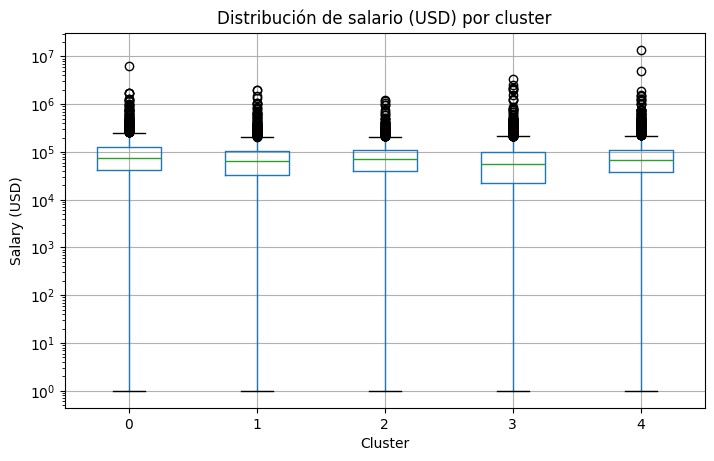

In [13]:
rq3_results.boxplot(column="salary_est", by="cluster", figsize=(8,5))
plt.title("Distribución de salario (USD) por cluster")
plt.suptitle("")
plt.xlabel("Cluster")
plt.ylabel("Salary (USD)")
plt.yscale("log")
plt.show()


## 12. Conclusión (RQ3)

Los resultados muestran que **sí existen perfiles tecnológicos diferenciables** a partir del stack reportado (lenguajes, bases de datos, frameworks, herramientas y plataformas). Mediante KMeans se identificaron cinco perfiles interpretables:

- **Python Backend/Data + Cloud**
- **Java/Spring Backend**
- **.NET / Microsoft Enterprise**
- **Modern JS Fullstack (React/Node)**
- **Systems / Low-level + Python**

La prueba **Kruskal–Wallis** confirmó diferencias salariales globales entre perfiles (**p ≪ 0.05**). El análisis post-hoc mostró que casi todos los perfiles difieren significativamente en salario, excepto entre **.NET / Microsoft Enterprise** y **Systems / Low-level + Python**, donde no se observó diferencia estadística significativa.

En escala monetaria, el perfil con mayor mediana salarial fue **Python Backend/Data + Cloud**, mientras que el más bajo fue **Modern JS Fullstack (React/Node)**. Por lo tanto, se concluye que **los perfiles tecnológicos están asociados a diferencias salariales significativas**.
